In [1]:
## !pip install qiskit --upgrade
!pip install qiskit[visualization] --quiet

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import qiskit
from qiskit_aer.backends import AerSimulator

# Exercise 6

## a)

In [3]:
def evolve_basic(circ, g, dt):
    # Applying exp(B)
    for i in range(len(circ.qubits)-1):
        circ.rzz(-dt, circ.qubits[i], circ.qubits[i+1])
        
    circ.barrier()
    
    # Applying exp(A)
    for i in range(len(circ.qubits)):
        circ.rx(-dt*g, circ.qubits[i])

    return circ

### Testing

In [4]:
circ = qiskit.QuantumCircuit(4)
circ.h(0)
circ.cx(0,1)
circ.barrier()

circ.h(1)
circ.cx(1,2)
circ.barrier()

circ.h(2)
circ.cx(2,3)
circ.barrier()

dt = 0.001
g = 1.0
evolved_circ = evolve_basic(circ, g, dt)
print(evolved_circ)


     ┌───┐      ░            ░            ░                           »
q_0: ┤ H ├──■───░────────────░────────────░──■────────────────────────»
     └───┘┌─┴─┐ ░ ┌───┐      ░            ░  │ZZ(-0.001)              »
q_1: ─────┤ X ├─░─┤ H ├──■───░────────────░──■────────────■───────────»
          └───┘ ░ └───┘┌─┴─┐ ░ ┌───┐      ░               │ZZ(-0.001) »
q_2: ───────────░──────┤ X ├─░─┤ H ├──■───░───────────────■───────────»
                ░      └───┘ ░ └───┘┌─┴─┐ ░                           »
q_3: ───────────░────────────░──────┤ X ├─░───────────────────────────»
                ░            ░      └───┘ ░                           »
«                   ░ ┌────────────┐
«q_0: ──────────────░─┤ Rx(-0.001) ├
«                   ░ ├────────────┤
«q_1: ──────────────░─┤ Rx(-0.001) ├
«                   ░ ├────────────┤
«q_2: ─■────────────░─┤ Rx(-0.001) ├
«      │ZZ(-0.001)  ░ ├────────────┤
«q_3: ─■────────────░─┤ Rx(-0.001) ├
«                   ░ └────────────┘


## b)

In [5]:
def evolve_symmetric(circ, g, dt):
    # Applying exp(A/2)
    for i in range(len(circ.qubits)):
        circ.rx(-dt*g/2, circ.qubits[i])
        
    circ.barrier()
        
    # Applying exp(B)
    for i in range(len(circ.qubits)-1):
        circ.rzz(-dt, circ.qubits[i], circ.qubits[i+1])
        
    circ.barrier()
    
    # Applying exp(A/2)
    for i in range(len(circ.qubits)):
        circ.rx(-dt*g/2, circ.qubits[i])

    return circ

### Testing

In [6]:
circ = qiskit.QuantumCircuit(4)
circ.h(0)
circ.cx(0,1)
circ.barrier()

circ.h(1)
circ.cx(1,2)
circ.barrier()

circ.h(2)
circ.cx(2,3)
circ.barrier()

dt = 0.001
g = 1.0
evolved_circ = evolve_symmetric(circ, g, dt)
print(evolved_circ)


     ┌───┐      ░            ░            ░ ┌─────────────┐ ░              »
q_0: ┤ H ├──■───░────────────░────────────░─┤ Rx(-0.0005) ├─░──■───────────»
     └───┘┌─┴─┐ ░ ┌───┐      ░            ░ ├─────────────┤ ░  │ZZ(-0.001) »
q_1: ─────┤ X ├─░─┤ H ├──■───░────────────░─┤ Rx(-0.0005) ├─░──■───────────»
          └───┘ ░ └───┘┌─┴─┐ ░ ┌───┐      ░ ├─────────────┤ ░              »
q_2: ───────────░──────┤ X ├─░─┤ H ├──■───░─┤ Rx(-0.0005) ├─░──────────────»
                ░      └───┘ ░ └───┘┌─┴─┐ ░ ├─────────────┤ ░              »
q_3: ───────────░────────────░──────┤ X ├─░─┤ Rx(-0.0005) ├─░──────────────»
                ░            ░      └───┘ ░ └─────────────┘ ░              »
«                                ░ ┌─────────────┐
«q_0: ───────────────────────────░─┤ Rx(-0.0005) ├
«                                ░ ├─────────────┤
«q_1: ─■─────────────────────────░─┤ Rx(-0.0005) ├
«      │ZZ(-0.001)               ░ ├─────────────┤
«q_2: ─■────────────■────────────░─┤ Rx(-0.0005) ├
«

## 

# Exercise 7

In [7]:
def individual_mz(bitstring):
    int_array = [int(x) for x in list(bitstring) if x!=' ']
    count_1 = sum(int_array)
    count_0 = len(int_array) - sum(int_array)
    
    return (count_0 - count_1)/len(int_array)

def avg_mz(counts_dict):
    numerator = denominator = 0
    for key in counts_dict:
        mz = individual_mz(key)
        numerator += mz*counts_dict[key]
        denominator += counts_dict[key]
    
    return numerator/denominator

In [8]:
# BASIC EVOLUTION

sim = AerSimulator()

N_shots = 1000  # number of measurements
dt = 0.03
g = 2.0
t_max = int(5/dt)
time_list = []
magnetization_list_basic = []

for exp_duration in range(t_max):
    evolved_circ = qiskit.QuantumCircuit(10)

    for t in range(exp_duration):
        evolved_circ = evolve_basic(evolved_circ, g, dt)
    
    evolved_circ.measure_all()
    result = sim.run(evolved_circ, shots=N_shots).result()
    counts_dict = result.get_counts(evolved_circ)

    avg_magnetization = avg_mz(counts_dict)
    time_list.append(exp_duration*dt)
    magnetization_list_basic.append(avg_magnetization)

In [9]:
# SYMMETRIC EVOLUTION

sim = AerSimulator()

N_shots = 1000  # number of measurements
dt = 0.03
g = 2.0
t_max = int(5/dt)
time_list = []
magnetization_list_symmetric = []

for exp_duration in range(t_max):
    evolved_circ = qiskit.QuantumCircuit(10)

    for t in range(exp_duration):
        evolved_circ = evolve_symmetric(evolved_circ, g, dt)
    
    evolved_circ.measure_all()
    result = sim.run(evolved_circ, shots=N_shots).result()
    counts_dict = result.get_counts(evolved_circ)

    avg_magnetization = avg_mz(counts_dict)
    time_list.append(exp_duration*dt)
    magnetization_list_symmetric.append(avg_magnetization)


In [10]:
import numpy as np

# define basic Pauli matrices
s_alpha = [np.array([[1, 0], [0, 1]], dtype='complex'),
           np.array([[0, 1], [1, 0]], dtype='complex'),
           np.array([[0, -1j], [1j, 0]],dtype='complex'),
           np.array([[1, 0], [0, -1]], dtype='complex')]


# define the many-body spin operators
def sp(alpha, n, N):
    Sa = s_alpha[alpha]
    for i in range(n):
        Sa = np.kron(s_alpha[0], Sa)
    for j in range(n+1, N):
        Sa = np.kron(Sa, s_alpha[0])
    return Sa


def magn_exact_diagonalization(N, g, t, Npoints):
    """
    Benchmark the Trotterized circuit evolution with the exact Hamiltonian time evolution,
    obtained through exact diagonalization (only for small system sizes N!). 
    This function returns the magnetization for equally spaced timesteps between  0  and  t .
    """
    # array containing the magnetization of individual basis states
    magnetization_basis_states = -np.array( [np.sum(2*np.array([int(bin(n)[2:].zfill(N)[i]) for i in range(N)]) - 1.0)/N for n in range(2**N)] )

    # create the hamiltonian
    hamiltonian = np.zeros((2**N, 2**N), dtype='complex')
    for i in range(N):
        hamiltonian += g/2*sp(1, i, N)
        if i != N-1:
            hamiltonian += -1/2*sp(3, i, N) @ sp(3, i+1, N)

    # diagonalize
    E, V = np.linalg.eig(hamiltonian)

    # time evolve
    magnetization = np.zeros(Npoints)
    initial_state = np.array([int(n==0) for n in range(2**N)])
    overlap = V.transpose().conj() @ initial_state
    for ind,T in enumerate(np.linspace(0,t,Npoints)):
        state_evolved = V @ (np.exp(-1j*T*E) * overlap)
        magnetization[ind] = np.sum(magnetization_basis_states * np.abs(state_evolved)**2)

    return magnetization


# Useful functions to verify whether a given density matrix is physical

def is_Hermitian(M, rtol = 1e-5, atol = 1e-9):
    return np.allclose(M, np.conjugate(M.T), rtol=rtol, atol=atol)

def is_positive(M, tol = 1e-7):
    s = np.linalg.eigvalsh(M)
    assert (s[0] > -tol)
    for i in range(len(s)):
      if s[i] <= 0:
         s[i] = 1e-12
    return s

In [11]:
N = 10
dt = 0.03
g = 2.0
t_max = int(5/dt)
t = 5
exact_diagonalization = magn_exact_diagonalization(N, g, t, t_max)

Text(0, 0.5, 'Magnetization')

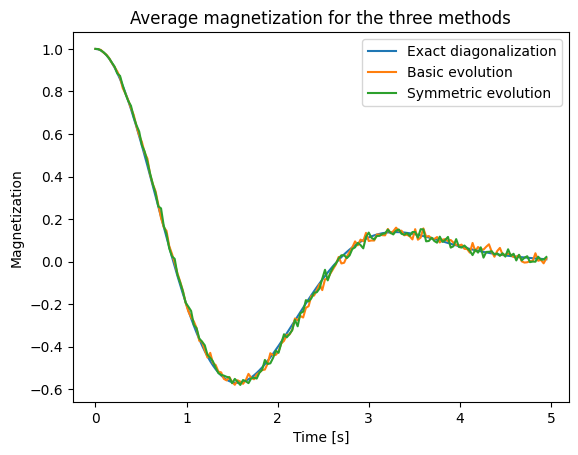

In [12]:
plt.plot(time_list, exact_diagonalization, label='Exact diagonalization')
plt.plot(time_list, magnetization_list_basic, label='Basic evolution')
plt.plot(time_list, magnetization_list_symmetric, label='Symmetric evolution')
plt.legend()
plt.title("Average magnetization for the three methods")
plt.xlabel("Time [s]")
plt.ylabel("Magnetization")
